In [2]:
import sys, os
sys.path.append(os.path.join('..', 'scripts'))
import figure_utils as utils
import lif_utils

In [3]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [4]:
from ssp_bayes_opt import sspspace
from scipy.stats import norm
import nengo

np.random.seed(0)

N=1000
X_data = np.concatenate(
    (np.random.normal(0,1,int(0.3*N)), np.random.normal(5,1, int(0.7*N)))
)[:, np.newaxis]
X_plot = np.linspace(-5,10,1000)[:,np.newaxis]
true_pdf = 0.3 * norm.pdf(X_plot[:,0]) + 0.7 * norm(5,1).pdf(X_plot[:,0])

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [5]:
ls=1
rand_space = sspspace.RandomSSPSpace(ssp_dim=2048, domain_dim=1)
rand_space.update_lengthscale(ls)

phis_data = rand_space.encode(X_data)
mu_data = np.mean(phis_data, axis=0) / ls

query_phis = rand_space.encode(X_plot)
sims = np.einsum('nd,d->n', query_phis, mu_data)

# Create single neuron that encodes distribution

Here the synaptic weights of the neuron encode the latent distribution encoded by the average of SSPs.


In [6]:
max_rate=50
model = nengo.Network()
with model: 
    ens = nengo.Ensemble(n_neurons=1, 
                        dimensions=rand_space.ssp_dim,
                        encoders=np.atleast_2d(mu_data),
                        radius=2.5,
                        intercepts=0 * np.ones((1,)),
                        max_rates=max_rate * np.ones((1,)),
                        neuron_type=nengo.neurons.SpikingRectifiedLinear())
    
sim = nengo.Simulator(model, progress_bar=None)
x_c, a_spiking_rect = nengo.utils.ensemble.tuning_curves(ens, sim, query_phis)

0.28470997691725086


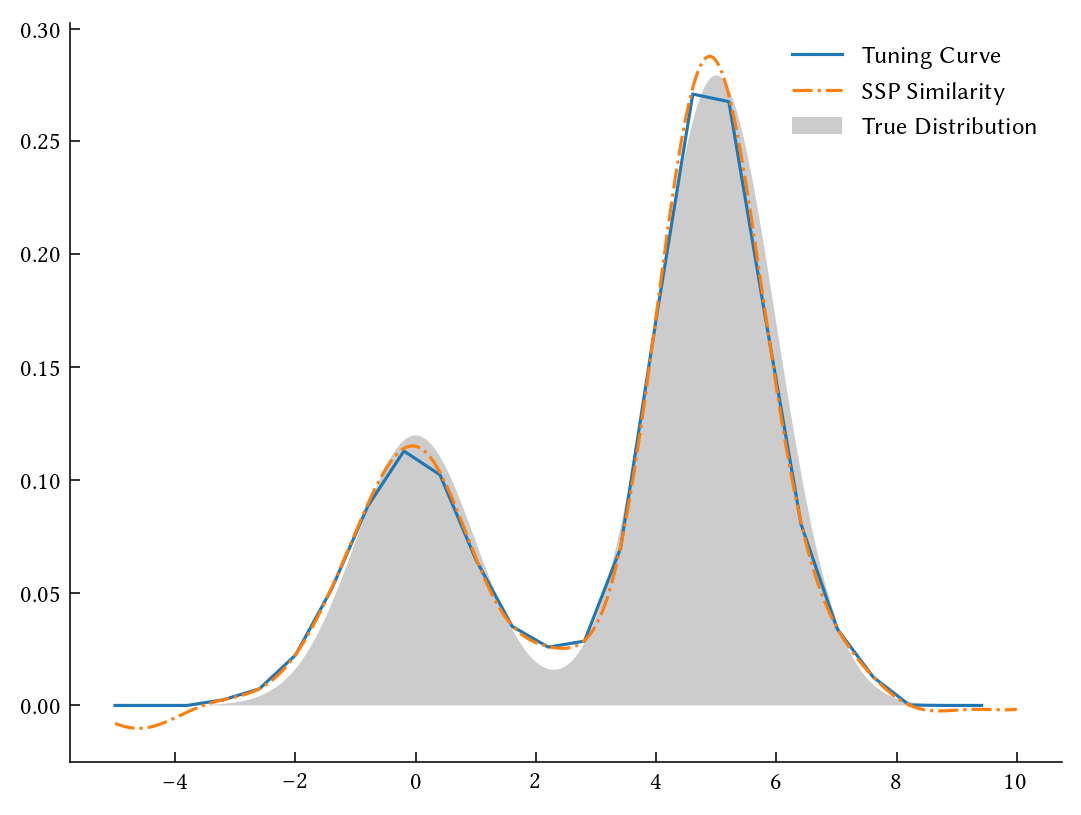

In [10]:
norm_spiking_rect = a_spiking_rect[:,0] / max_rate

print(norm_spiking_rect.max())

plt.plot(X_plot, norm_spiking_rect, label='Tuning Curve')
plt.plot(X_plot, sims, ls='-.', label='SSP Similarity')
plt.fill(X_plot, true_pdf, fc='black', alpha=0.2, label='True Distribution')
plt.legend()
plt.show()

# Encode Probability in Neural Population

In this encoding, the average activity of the $i^{th}$ neuron, $\langle a_{i}(t) \rangle$, corresponds to a sample point, $x_i \in \mathcal{X}$.

In [54]:
model = nengo.Network()
with model:
    ens = nengo.Ensemble(n_neurons=query_phis.shape[0],
                        dimensions=rand_space.ssp_dim,
                        encoders=query_phis,
                        intercepts = np.zeros((query_phis.shape[0],)),
                        max_rates=max_rate * np.ones((query_phis.shape[0],)),
                        neuron_type=nengo.neurons.SpikingRectifiedLinear(),
                        )
    def stim_func(t):
        return mu_data.flatten()
    stim = nengo.Node(stim_func)
    nengo.Connection(stim, ens)
    p_ens = nengo.Probe(ens.neurons)
    
with nengo.Simulator(model) as sim:
    sim.run(3)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

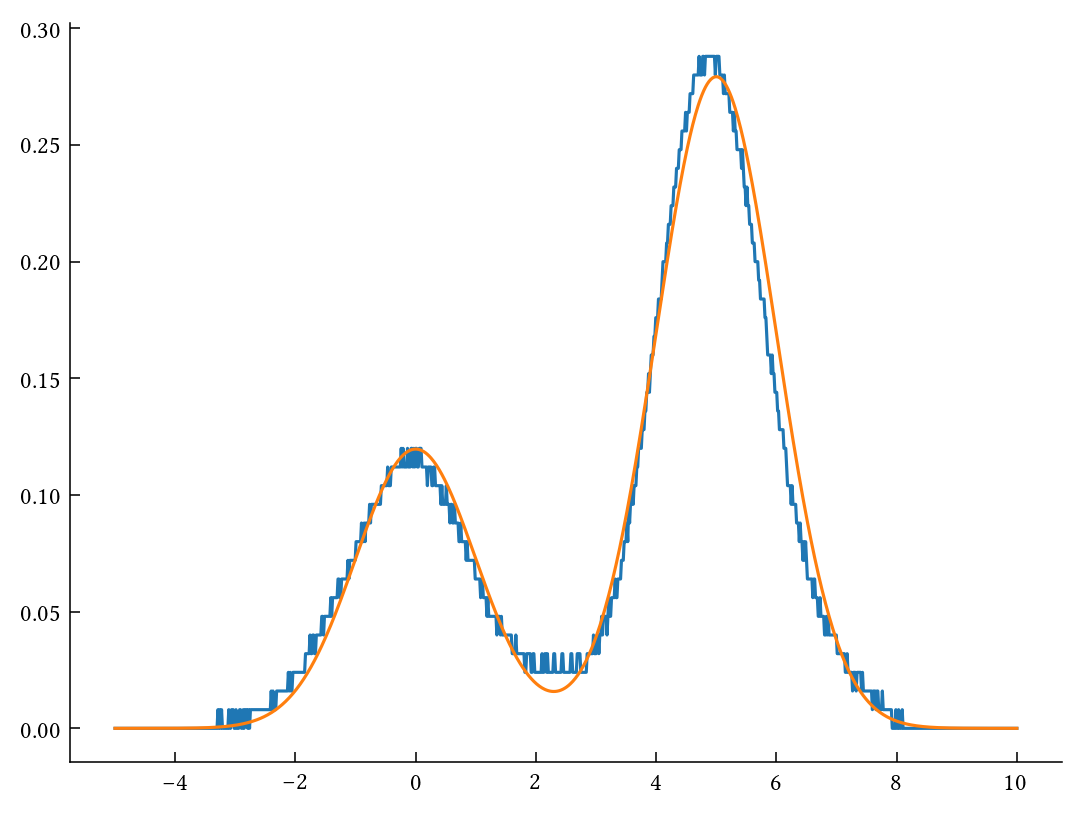

In [55]:
firing_rate = np.mean(sim.data[p_ens][500:,:], axis=0) / max_rate

plt.figure()
plt.plot(X_plot, firing_rate)
plt.plot(X_plot, true_pdf)

Saving to probability_tuning_curve.large.pdf
Extracting bounding box of file probability_tuning_curve.large.pdf
Optimising PDF and saving to probability_tuning_curve.pdf


GPL Ghostscript 9.50: Can't embed the complete font LibertinusT1Math as it is too large, embedding a subset.
GPL Ghostscript 9.50: Can't embed the complete font LinBiolinumT as it is too large, embedding a subset.
GPL Ghostscript 9.50: Can't embed the complete font LibertinusT1Math as it is too large, embedding a subset.
GPL Ghostscript 9.50: Can't embed the complete font LinBiolinumTB as it is too large, embedding a subset.


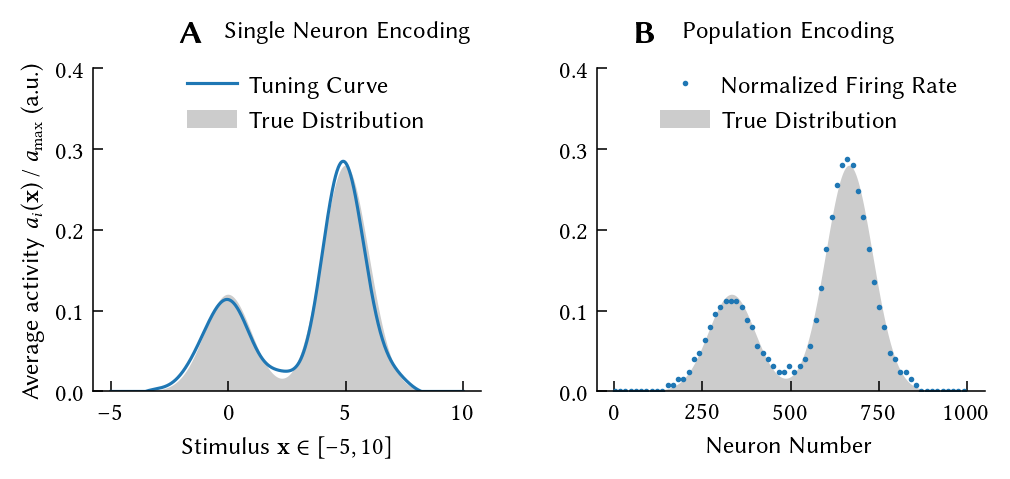

In [56]:
fig, (ax1, ax2) = plt.subplots(1,
                               2,
                               figsize=(5.75, 2.1),
                               gridspec_kw={
                                   "wspace": 0.3,
                                   "width_ratios": [3.75, 3.75]
                               })

#for spine in ["left", "bottom"]:
#    ax1.spines[spine].set_visible(False)
#ax1.set_xticks([])
#ax1.set_yticks([])

#ax1.set_xlim(-1, 4)
ax1.set_ylim(0, 0.4)


ax1.plot(X_plot, norm_spiking_rect, label='Tuning Curve')
#ax1.plot(X_plot, sims, ls='-.', label='SSP Similarity')
ax1.fill(X_plot, true_pdf, fc='black', alpha=0.2, label='True Distribution')

ax1.set_title('{Tuning curve}', y=1.025, va="bottom")

ax1.set_ylabel('Average activity $a_i(\\vec{x})$ / $a_{\\mathrm{max}}$ (a.u.)')
ax1.set_xlabel('Stimulus $\\vec x \\in [-5,10]$')

ax1.legend(loc="upper center", ncol=1, 
           bbox_to_anchor=(0.55, 1.05), 
           columnspacing=1.0, handlelength=2, handletextpad=0.5)


ax1.text(0.22,
         1.0555,
         '\\textbf{A}',
         fontsize=12,
         transform=ax1.transAxes,
         va="bottom")
ax1.set_title('{Single Neuron Encoding}', x=0.66, y=1.025, va="bottom")


stride=15

ax2.plot(np.arange(1,X_plot.shape[0]+1,stride), firing_rate[::stride], 'o', markersize=1, lw=0, label='Normalized Firing Rate')
ax2.fill(np.arange(1,X_plot.shape[0]+1), true_pdf, fc='black', alpha=0.2, label='True Distribution')
ax2.set_ylim(0, 0.4)


ax2.text(0.1,
         1.0555,
         '\\textbf{B}',
         fontsize=12,
         transform=ax2.transAxes,
         va="bottom")

ax2.set_title('{Population Encoding}', y=1.025, va="bottom")
#ax2.set_ylabel('Normalized Average Activity $a_i(\\vec{x})$ / $a_\\mathrm{max}$')
ax2.set_xlabel('Neuron Number')


ax2.legend(loc="upper center", ncol=1, bbox_to_anchor=(0.55, 1.05), columnspacing=1.0, handlelength=2, handletextpad=0.5)

utils.save(fig, "probability_tuning_curve.pdf")